# General workflow
This workflow is a starting point to demonstrate the functionality of the containers and to detect and classify difficult cases

In [1]:

import numpy as np
import pandas as pd
import skimage
import Images
import ModelUNet_rep
import copy



/home/lienhard/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#some definitions
debug=False #perform on a subset --> faster
model_shape=(256,256,3) #works with shape (2^x, 2^x) only?
model_name='unet_boundaries_{}x{}'.format(model_shape[0],model_shape[1])
if debug:
    model_name += '_debug'

print('the model will be called \''+model_name+'\'')


the model will be called 'unet_boundaries_256x256'


## Training
* load training data
* train the model (if not yet done)
* 

100%|██████████| 603/603 [01:48<00:00,  5.55it/s]


                                                   ids  size_x  size_y  \
344  80632d6be60c8462e50d51bcf5caf15308931603095d6b...     512     640   

     n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
344           1        36           1143           719           114   

     nuclei_maxSz  
344          3218  


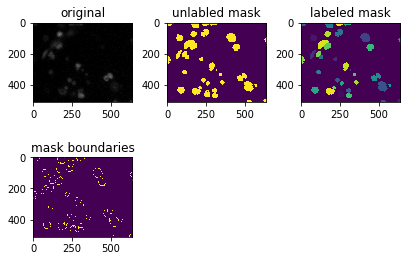

In [3]:
train=Images.Images("../input/stage1_train")
if debug:
    #subselect, to make it faster 
    train=train.subset(idx=range(20))
    #todo: overload [] to get this

#set aside 10% for validation
val=train.subset(np.arange(train.n()*.9, train.n()))
train=train.subset(np.arange(train.n()*.9,))

#load the image files (in original size)    
train.load_images()
train.load_masks()
train.features.head()    

train.show_image()

In [4]:

#we want to learn the boundaries
trainmasks=train.masks
train.masks=copy.deepcopy(train.mask_boundaries)
valmasks=val.masks
val.masks=copy.deepcopy(val.mask_boundaries)
train.show_image()

In [5]:
# initialize and train the model 
# to detect unlabled masks (e.g. the forground vs background)


m_file=model_name+'.h5'

model=ModelUNet_rep.ModelUNet(m_file=m_file, shape=(256,256,3))
#question: should the model design be adapted according to image dimensions?
if not model.trained:
    model.fit_model(train)


Train on 542 samples, validate on 61 samples
Epoch 1/50
528/542 [============================>.] - ETA: 6s - loss: 0.8848 - mean_iou: 0.3791 
Epoch 00001: val_loss improved from inf to 0.79582, saving model to unet_boundaries_256x256.h5
542/542 [==============================] - 272s 502ms/step - loss: 0.8841 - mean_iou: 0.3792 - val_loss: 0.7958 - val_mean_iou: 0.3895
Epoch 2/50
528/542 [============================>.] - ETA: 6s - loss: 0.8479 - mean_iou: 0.3965 
Epoch 00002: val_loss improved from 0.79582 to 0.74821, saving model to unet_boundaries_256x256.h5
542/542 [==============================] - 267s 493ms/step - loss: 0.8467 - mean_iou: 0.3965 - val_loss: 0.7482 - val_mean_iou: 0.4011
Epoch 3/50
528/542 [============================>.] - ETA: 6s - loss: 0.8288 - mean_iou: 0.4046 
Epoch 00003: val_loss improved from 0.74821 to 0.72655, saving model to unet_boundaries_256x256.h5
542/542 [==============================] - 269s 496ms/step - loss: 0.8296 - mean_iou: 0.4047 - val_lo

Epoch 28/50
528/542 [============================>.] - ETA: 6s - loss: 0.4803 - mean_iou: 0.5972 
Epoch 00028: val_loss improved from 0.40502 to 0.40294, saving model to unet_boundaries_256x256.h5
542/542 [==============================] - 268s 494ms/step - loss: 0.4803 - mean_iou: 0.5973 - val_loss: 0.4029 - val_mean_iou: 0.5990
Epoch 29/50
528/542 [============================>.] - ETA: 6s - loss: 0.4774 - mean_iou: 0.6007 
Epoch 00029: val_loss did not improve
542/542 [==============================] - 267s 493ms/step - loss: 0.4777 - mean_iou: 0.6007 - val_loss: 0.4071 - val_mean_iou: 0.6024
Epoch 30/50
528/542 [============================>.] - ETA: 6s - loss: 0.4773 - mean_iou: 0.6040 
Epoch 00030: val_loss did not improve
542/542 [==============================] - 268s 494ms/step - loss: 0.4766 - mean_iou: 0.6041 - val_loss: 0.4033 - val_mean_iou: 0.6057
Epoch 31/50
528/542 [============================>.] - ETA: 6s - loss: 0.4821 - mean_iou: 0.6072 
Epoch 00031: val_loss did no

making predictions...
rescale probability vector...
skimage version: 0.13.1
labeling predictions...
   size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
0     256     256           1        27            211           132   
1     256     256           1        36            131            37   
2     256     320           3        70            419           208   
3     256     320           3        86            168           151   
4     256     320           3         7            813           402   

   nuclei_minSz  nuclei_maxSz  iou_score  iou_th50  iou_th95  
0            21           460        0.0       0.0       0.0  
1            35           276        0.0       0.0       0.0  
2            56          1067        0.0       0.0       0.0  
3            22           752        0.0       0.0       0.0  
4           152          1563        0.0       0.0       0.0  
expected LB score(train): 0.0012437810945273632
                                         

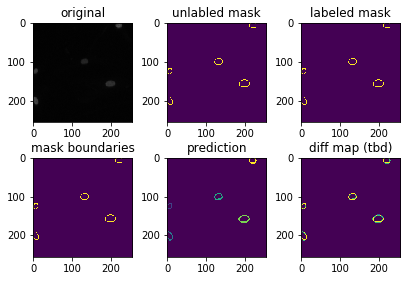

In [6]:

#unlabled prediction (probability of pixle belonging to forground) 
#scaled to the dimensions of the model (e.g. 256x256)
print('making predictions...')
scaled_pred=model.predict_unlabeld(train)


print('rescale probability vector...')
# rescaling performs anti-aliasing, which can disturb lable masks
# it cannot be swhiched of for my version of skimage 0.13.1, only with dev0.14
print("skimage version: {}".format(skimage.__version__))
# for the probability vector antialiasing should be rather beneficial
unlab_pred=train.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predictions...')
pred=model.label(unlab_pred, th=0.5) #this function should also use the images
#add labled predictions to container
train.add_pred(pred)
# this adds iou scores to train.features
print( train.features.drop(['ids'], axis=1).head() ) 
print("expected LB score(train): {}".format(np.mean(train.features['iou_score'])))

train.show_image()

                                                  ids  size_x  size_y  \
75  1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1...     520     696   

    n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
75           1       136            645           184            96   

    nuclei_maxSz  iou_score  iou_th50  iou_th95  
75          1160        0.0       0.0       0.0  


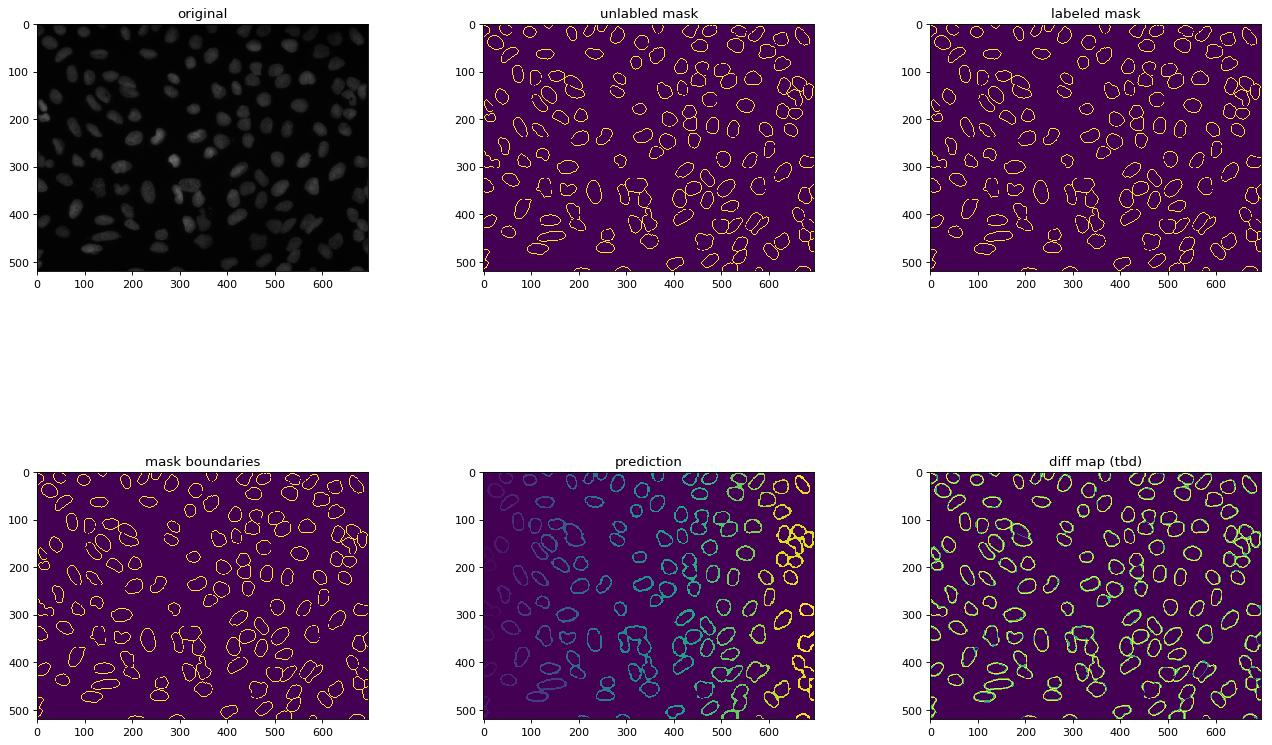

In [22]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
train.show_image()

In [23]:
#same on validation data
val.load_images()
val.load_masks()
print('making predictions...')
scaled_pred=model.predict_unlabeld(val)
print('rescale probability vector...')
unlab_pred=val.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')
print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5) 
val.add_pred(pred)
val.features.drop(['ids'], axis=1).head()
print("expected LB score(val): {}".format(np.mean(val.features['iou_score'])))


100%|██████████| 67/67 [00:13<00:00,  5.09it/s]


making predictions...
rescale probability vector...
labeling predinctions...
expected LB score(val): 0.0004305089808212975


                                                  ids  size_x  size_y  \
19  edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6...     256     256   

    n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
19           1        49            364           153            25   

    nuclei_maxSz  iou_score  iou_th50  iou_th95  nuclei_n  nuclei_meanSz  \
19           927        0.0       0.0       0.0        49            364   

    nuclei_stdSz  nuclei_minSz  nuclei_maxSz  
19           153            25           927  


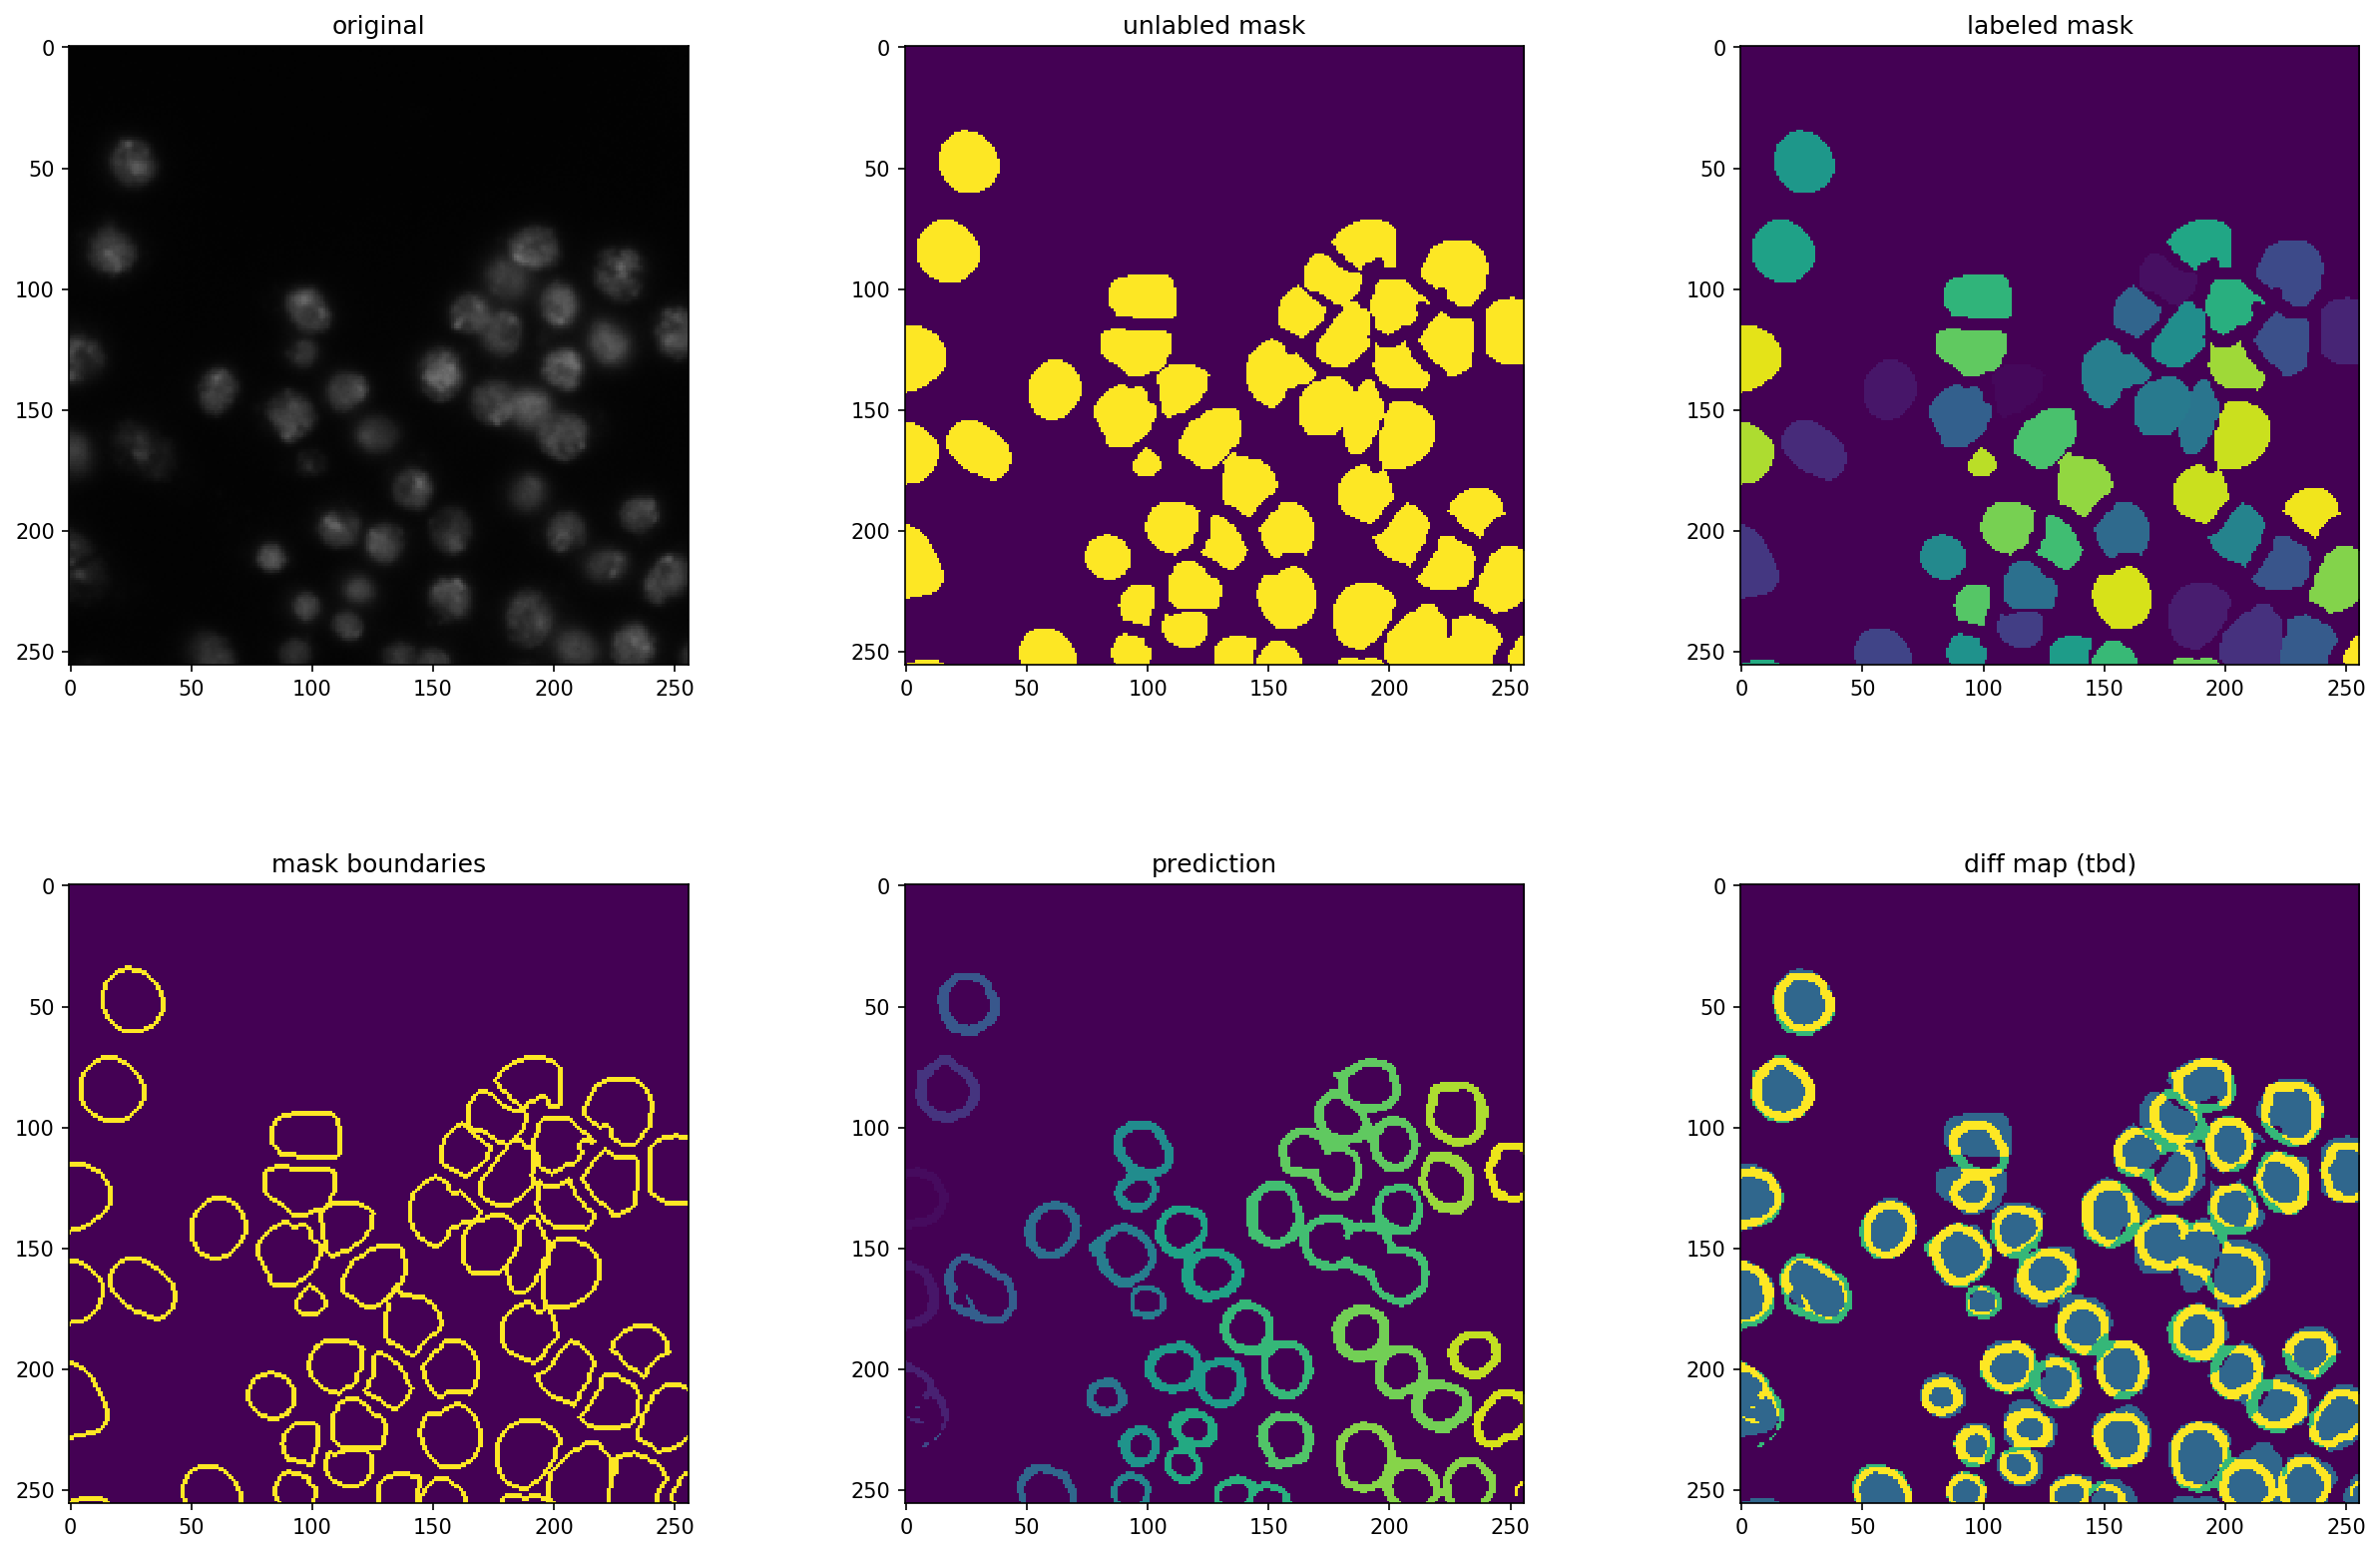

In [27]:
fig=plt.figure(figsize=(18, 12), dpi= 150, facecolor='w', edgecolor='k')
val.show_image()

## Prediction (on test data)
* load test data
* use model to predict masks
* prepare submission file

In [10]:
test=Images.Images("../input/stage1_test")

#load the image files (in original size)    
test.load_images()

test.features.head()    


100%|██████████| 65/65 [00:00<00:00, 97.44it/s] 


,ids,size_x,size_y,n_channels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,256,256,1
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,519,253,1
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,256,256,1
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,256,256,1
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,256,256,1


In [11]:
print('making predictions...')
scaled_pred=model.predict_unlabeld(test)


print('rescale probability vector...')
unlab_pred=test.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5)
test.add_pred(pred)


making predictions...
rescale probability vector...
labeling predinctions...


In [12]:
submission_file='submission' + model_name + '.csv'
test.write_submission(submission_file)



0

Scores for first test image:
unlabeled IoU: [0.]
unlabeled IoU per nucleus: [0. 0. 0. 0. 0. 0.]
mean IoU: 0.0
fraction of nuclei has IoU > 0.5: 0.0
fraction of nuclei has IoU > 0.95: 0.0
IoU score (over range of thresholds): 0.0
                                                 ids  size_x  size_y  \
0  e5f8ad0f0a43af8ca57e31e16800108abdfb44a7e962a7...     256     256   

   n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
0           1         6            198            72            85   

   nuclei_maxSz  iou_score  iou_th50  iou_th95  
0           282        0.0       0.0       0.0  


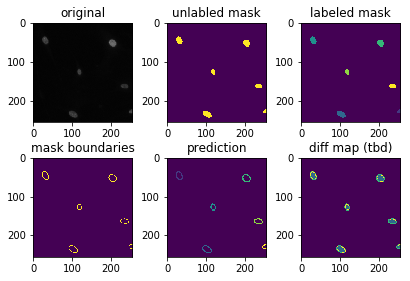

In [13]:

##########
# scores #
##########
print('Scores for first test image:')
#unlabeled IOU
print('IoU: {}'.format(Images.iou(val.masks[0] > 0, unlab_pred[0]>0.5)))
#labled IOUs per nucleus
print('IoU per nucleus: {}'.format(Images.iou(val.masks[0], val.pred[0])))
#mean IOU
print('mean IoU: {}'.format(np.mean(Images.iou(val.masks[0], val.pred[0]))))
# fraction of nuclei > th
print('fraction of nuclei has IoU > 0.5: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.5])))
print('fraction of nuclei has IoU > 0.95: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.95])))
# fraction of nuclei > th average over range of thresholds
print('IoU score (over range of thresholds): {}'.format(Images.iou_score(val.masks[0], val.pred[0])))

val.show_image(0)